In [17]:
import torch
import torch.optim
import torch.nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
plt.ion()

# Load Data
We have about 120 training images each for ants and bees. There are 75 validation images for each class.

## Data Augmentation and normalization for training

In [18]:
data_transforms = {
    'train': transforms.Compose({
        transforms.RandomResizedCrop(224), # Crop the given PIL Image to random size and aspect ratio
        transforms.RandomHorizontalFlip(), # Horizontally/Vertically flip the given PIL Image randomly with a given probability
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229, 0.224, 0.225]) # normalize the data with given mean and variance
    }),
    'val': transforms.Compose({
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229, 0.224, 0.225])
    })
}

## Dataloader
from ImageFolder to DataLoader

In [19]:
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

## Visualize a few images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


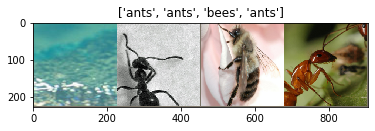

In [20]:
def imshow(inp,title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs,classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out,title = [class_names[x] for x in classes])

In [25]:
inputs.shape,classes.shape
model_ft.train()
output=model_ft(inputs.cuda()).cpu()
model_ft.criterion(output,classes)

tensor(0.6237, grad_fn=<NllLossBackward>)

In [26]:
output

tensor([[ 0.2234, -0.5473],
        [ 0.0163,  0.1714],
        [-0.2138,  0.1403],
        [-0.1506,  0.0692]], grad_fn=<CopyBackwards>)

# Definininf the Model
## Finetuning the convnet

In [92]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = torch.nn.Linear(num_ftrs, len(class_names)) # add one more layer to convert the result to the number we expected
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [93]:
model_ft.criterion = torch.nn.CrossEntropyLoss()
model_ft.metric_name = 'CrossEntropy'
model_ft.optimizer = torch.optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)
model_ft.scheduler = lr_scheduler.StepLR(model_ft.optimizer,step_size=7,gamma=0.1) # Decays the learning rate of each parameter group by gamma every step_size epochs

## ConvNet as fixed feature extractor
Freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

In [106]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
# only the parameters of the newly built part requires_grad=True
num_ftrs = model_conv.fc.in_features
model_conv.fc = torch.nn.Linear(num_ftrs,len(classes))

In [112]:
model_conv.optimizer = torch.optim.Adam(model_conv.parameters(),lr=0.001)
model_conv.criterion = torch.nn.CrossEntropyLoss()
model_conv.scheduler = torch.optim.lr_scheduler.StepLR(model_conv.optimizer, step_size=7, gamma=0.1)

In [ ]:
## 

# Training the Model

In [94]:
import datetime
def timebar():
    now = datetime.datetime.now().strftime('%Y-%M-%D %H:%M:%S')
    print('*****'*8+'%s'%now)
    pass
timebar()

****************************************2020-27-10/13/20 19:27:38


In [96]:
def train_process(model,dl_train,dl_val,epochs,log_step_freq,device=device):
    df_history = pd.DataFrame(columns=['epoch','loss','val_loss','auc','val_auc'])
    model.to(device)
    for epoch in range(1,epochs+1):
        timebar()
        print('Epoch: %d\n'%epoch)
        
        model.train()
        loss_sum = 0
        auc_sum = 0
        num_ins = 0
        for step,(inputs,classes) in enumerate(dl_train,1):
            num_ins += len(inputs) 
            inputs,classes = inputs.to(device),classes.to(device)
            
            model.optimizer.zero_grad()
            
            output = model(inputs)
            pred = output.argmax(dim=1)
            auc = torch.sum(classes==pred)
            loss = model.criterion(output,classes)
            
            loss.backward()
            
            model.optimizer.step()
            
            loss_sum += loss.item()*len(inputs)
            auc_sum += auc.item()
            
            if step%log_step_freq == 0:
                print('[step %d] loss = %.3f auc = %.3f'%(step,loss_sum/num_ins,auc_sum/num_ins))
        model.scheduler.step()
        
        model.eval()
        val_loss_sum = 0
        val_auc_sum = 0
        val_num_ins = 0
        for val_step,(val_inputs,val_classes) in enumerate(dl_val,1):
            val_inputs,val_classes = val_inputs.to(device),val_classes.to(device)
            val_num_ins += len(val_inputs)
            with torch.no_grad():
                val_output = model(val_inputs)
                val_pred  = val_output.argmax(dim=1)
                val_loss = model.criterion(val_output,val_classes)
                val_auc = torch.sum(val_pred==val_classes)
                val_loss_sum += val_loss.item()*len(val_inputs)
                val_auc_sum += val_auc.item()
    
        info = (epoch, loss_sum/num_ins, val_loss_sum/val_num_ins, auc_sum/num_ins, val_auc_sum/val_num_ins)
        print('===='*8+'Epoch %d loss = %.3f val_loss = %.3f auc = %.3f val_auc = %.3f'%info)
        
        df_history.loc[epoch-1]=info
    return df_history

In [97]:
train_process(model_ft,dataloaders['train'],dataloaders['val'],epochs=25,log_step_freq=4,device=torch.device('cuda'))

****************************************2020-27-10/13/20 19:27:50
Epoch: 1

[step 4] loss = 0.628 auc = 0.625
[step 8] loss = 0.710 auc = 0.562
[step 12] loss = 0.634 auc = 0.646
[step 16] loss = 0.677 auc = 0.609
[step 20] loss = 0.706 auc = 0.613
[step 24] loss = 0.706 auc = 0.615
[step 28] loss = 0.654 auc = 0.643
[step 32] loss = 0.716 auc = 0.625
[step 36] loss = 0.658 auc = 0.660
[step 40] loss = 0.611 auc = 0.688
[step 44] loss = 0.669 auc = 0.688
[step 48] loss = 0.660 auc = 0.688
[step 52] loss = 0.670 auc = 0.683
[step 56] loss = 0.668 auc = 0.688
[step 60] loss = 0.671 auc = 0.692
================================Epoch 1 loss = 0.663 val_loss = 0.213 auc = 0.697 val_auc = 0.922
****************************************2020-27-10/13/20 19:27:59
Epoch: 2

[step 4] loss = 0.851 auc = 0.625
[step 8] loss = 0.556 auc = 0.750
[step 12] loss = 1.114 auc = 0.562
[step 16] loss = 0.890 auc = 0.641
[step 20] loss = 0.842 auc = 0.675
[step 24] loss = 0.798 auc = 0.698
[step 28] loss = 0.

[step 56] loss = 0.325 auc = 0.853
[step 60] loss = 0.354 auc = 0.846
================================Epoch 12 loss = 0.349 val_loss = 0.193 auc = 0.848 val_auc = 0.935
****************************************2020-29-10/13/20 19:29:48
Epoch: 13

[step 4] loss = 0.348 auc = 0.875
[step 8] loss = 0.405 auc = 0.875
[step 12] loss = 0.397 auc = 0.875
[step 16] loss = 0.378 auc = 0.875
[step 20] loss = 0.366 auc = 0.875
[step 24] loss = 0.328 auc = 0.885
[step 28] loss = 0.291 auc = 0.902
[step 32] loss = 0.264 auc = 0.914
[step 36] loss = 0.244 auc = 0.917
[step 40] loss = 0.245 auc = 0.912
[step 44] loss = 0.277 auc = 0.898
[step 48] loss = 0.259 auc = 0.906
[step 52] loss = 0.263 auc = 0.899
[step 56] loss = 0.268 auc = 0.893
[step 60] loss = 0.263 auc = 0.892
================================Epoch 13 loss = 0.261 val_loss = 0.231 auc = 0.893 val_auc = 0.902
****************************************2020-29-10/13/20 19:29:57
Epoch: 14

[step 4] loss = 0.455 auc = 0.750
[step 8] loss = 0.365

[step 36] loss = 0.269 auc = 0.889
[step 40] loss = 0.277 auc = 0.887
[step 44] loss = 0.262 auc = 0.892
[step 48] loss = 0.273 auc = 0.891
[step 52] loss = 0.265 auc = 0.894
[step 56] loss = 0.273 auc = 0.888
[step 60] loss = 0.260 auc = 0.896
================================Epoch 24 loss = 0.256 val_loss = 0.178 auc = 0.898 val_auc = 0.961
****************************************2020-31-10/13/20 19:31:47
Epoch: 25

[step 4] loss = 0.332 auc = 0.938
[step 8] loss = 0.222 auc = 0.969
[step 12] loss = 0.189 auc = 0.979
[step 16] loss = 0.190 auc = 0.969
[step 20] loss = 0.215 auc = 0.950
[step 24] loss = 0.218 auc = 0.948
[step 28] loss = 0.212 auc = 0.946
[step 32] loss = 0.212 auc = 0.945
[step 36] loss = 0.221 auc = 0.931
[step 40] loss = 0.245 auc = 0.912
[step 44] loss = 0.235 auc = 0.915
[step 48] loss = 0.225 auc = 0.922
[step 52] loss = 0.229 auc = 0.918
[step 56] loss = 0.218 auc = 0.924
[step 60] loss = 0.212 auc = 0.929
================================Epoch 25 loss = 0.217 va

,epoch,loss,val_loss,auc,val_auc
0,1.0,0.662890,0.212567,0.696721,0.921569
1,2.0,0.808092,0.387319,0.709016,0.843137
2,3.0,0.980235,0.590997,0.737705,0.751634
3,4.0,0.494559,0.831214,0.782787,0.679739
4,5.0,0.443800,0.512611,0.819672,0.810458
5,6.0,0.409694,0.237386,0.852459,0.928105
6,7.0,0.599385,0.397743,0.725410,0.836601
7,8.0,0.298478,0.221643,0.868852,0.915033
8,9.0,0.396579,0.240771,0.840164,0.908497
9,10.0,0.295075,0.213224,0.868852,0.921569


****************************************2020-36-10/13/20 23:36:32
Epoch: 1

[step 4] loss = 0.296 auc = 0.938
[step 8] loss = 0.258 auc = 0.938
[step 12] loss = 0.228 auc = 0.958
[step 16] loss = 0.253 auc = 0.938
[step 20] loss = 0.278 auc = 0.912
[step 24] loss = 0.286 auc = 0.906
[step 28] loss = 0.306 auc = 0.911
[step 32] loss = 0.297 auc = 0.914
[step 36] loss = 0.332 auc = 0.889
[step 40] loss = 0.314 auc = 0.900
[step 44] loss = 0.333 auc = 0.886
[step 48] loss = 0.328 auc = 0.891
[step 52] loss = 0.317 auc = 0.889
[step 56] loss = 0.327 auc = 0.879
[step 60] loss = 0.335 auc = 0.871
================================Epoch 1 loss = 0.332 val_loss = 0.157 auc = 0.873 val_auc = 0.961
****************************************2020-36-10/13/20 23:36:44
Epoch: 2

[step 4] loss = 0.324 auc = 0.938
[step 8] loss = 0.308 auc = 0.875
[step 12] loss = 0.351 auc = 0.833
[step 16] loss = 0.332 auc = 0.844
[step 20] loss = 0.322 auc = 0.850
[step 24] loss = 0.339 auc = 0.833
[step 28] loss = 0.

[step 56] loss = 0.308 auc = 0.866
[step 60] loss = 0.328 auc = 0.854
================================Epoch 12 loss = 0.327 val_loss = 0.158 auc = 0.857 val_auc = 0.961
****************************************2020-38-10/13/20 23:38:51
Epoch: 13

[step 4] loss = 0.413 auc = 0.812
[step 8] loss = 0.334 auc = 0.844
[step 12] loss = 0.326 auc = 0.833
[step 16] loss = 0.321 auc = 0.859
[step 20] loss = 0.316 auc = 0.838
[step 24] loss = 0.287 auc = 0.865
[step 28] loss = 0.314 auc = 0.857
[step 32] loss = 0.329 auc = 0.852
[step 36] loss = 0.328 auc = 0.854
[step 40] loss = 0.316 auc = 0.869
[step 44] loss = 0.314 auc = 0.864
[step 48] loss = 0.317 auc = 0.854
[step 52] loss = 0.318 auc = 0.856
[step 56] loss = 0.325 auc = 0.853
[step 60] loss = 0.312 auc = 0.863
================================Epoch 13 loss = 0.308 val_loss = 0.168 auc = 0.865 val_auc = 0.961
****************************************2020-39-10/13/20 23:39:02
Epoch: 14

[step 4] loss = 0.298 auc = 0.875
[step 8] loss = 0.445

[step 36] loss = 0.343 auc = 0.833
[step 40] loss = 0.350 auc = 0.825
[step 44] loss = 0.388 auc = 0.801
[step 48] loss = 0.383 auc = 0.797
[step 52] loss = 0.378 auc = 0.803
[step 56] loss = 0.380 auc = 0.795
[step 60] loss = 0.369 auc = 0.804
================================Epoch 24 loss = 0.364 val_loss = 0.156 auc = 0.807 val_auc = 0.954
****************************************2020-41-10/13/20 23:41:06
Epoch: 25

[step 4] loss = 0.214 auc = 0.875
[step 8] loss = 0.255 auc = 0.875
[step 12] loss = 0.246 auc = 0.875
[step 16] loss = 0.282 auc = 0.844
[step 20] loss = 0.280 auc = 0.863
[step 24] loss = 0.268 auc = 0.885
[step 28] loss = 0.266 auc = 0.893
[step 32] loss = 0.272 auc = 0.898
[step 36] loss = 0.283 auc = 0.896
[step 40] loss = 0.313 auc = 0.875
[step 44] loss = 0.302 auc = 0.881
[step 48] loss = 0.309 auc = 0.875
[step 52] loss = 0.313 auc = 0.875
[step 56] loss = 0.310 auc = 0.875
[step 60] loss = 0.313 auc = 0.871
================================Epoch 25 loss = 0.313 va

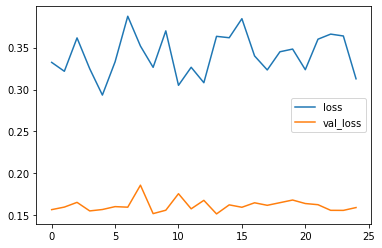

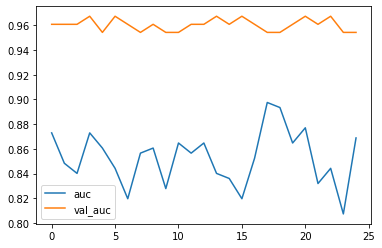

In [119]:
history_conv=train_process(model_conv,dataloaders['train'],dataloaders['val'],epochs=25,log_step_freq=4,device=torch.device('cuda'))
history_conv[['loss','val_loss']].plot()
history_conv[['auc','val_auc']].plot()

# Visualization

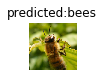

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


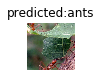

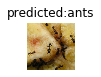

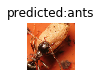

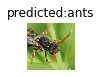

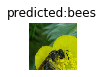

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


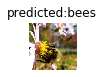

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


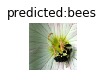

In [103]:
def visualize_model(model,num_images=8):
    was_training = model_ft.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i,(inputs,labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = inputs.to(device)
            
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            
            for j in range(len(inputs)):
                images_so_far += 1
                ax = plt.subplot(num_images//2,2,images_so_far)
                ax.axis('off')
                ax.set_title('predicted:{}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)